# Prédiction des urgences

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy

from imblearn.over_sampling import SMOTE
from collections import Counter

2023-11-12 20:21:27.694950: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 20:21:30.208952: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 20:21:30.209007: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 20:21:30.223424: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 20:21:31.270070: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 20:21:31.271478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
data_path = "data/clean_data.parquet"
df = pd.read_parquet(data_path)

In [5]:
df.head()

,No Cas,date_entree,date_sortie,date_naissance,sexe,cim_diag_pr,ccam_1,ccam_2,ccam_3,ccam_4,...,heure_incision,heure_sortie_salle,anesth_type,anesth_loco_reg,duree_sejour,interv_type,duree_sspi,duree_op,age,urgence
0,1678286,2019-01-04,2019-01-04,1961-09-20,2,140,354,470,388,9,...,0 days 14:29:00,0 days 15:10:00,5,13,1,1009,0 days 00:51:00,0 days 00:57:00,20925 days,False
1,1676952,2019-01-03,2019-01-03,1966-02-15,1,475,34,506,17,-1,...,0 days 00:00:00,0 days 08:45:00,5,10,1,810,0 days 00:30:00,0 days 00:45:00,19315 days,True
2,1661837,2019-01-03,2019-01-03,1964-08-14,2,140,365,338,328,218,...,0 days 08:29:00,0 days 09:40:00,-1,13,1,1011,0 days 00:39:00,0 days 01:32:00,19865 days,False
3,1680505,2019-01-04,2019-01-04,2004-10-29,2,362,143,134,388,9,...,0 days 09:07:00,0 days 09:31:00,4,17,1,810,0 days 00:37:00,0 days 00:49:00,5180 days,False
4,1681248,2019-01-04,2019-01-04,2006-06-12,1,61,531,548,17,-1,...,0 days 12:29:00,0 days 12:36:00,0,1,1,1348,0 days 00:34:00,0 days 00:16:00,4589 days,False


# Analyse

In [60]:
df_urgences = df.query("urgence == True")
df_urgences = df_urgences[np.isfinite(df_urgences['date_entree'])]
df_urgences = df_urgences[np.isfinite(df_urgences['heure_entree_sspi'])]

timestamp = df_urgences['date_entree'] + df_urgences['heure_entree_sspi']

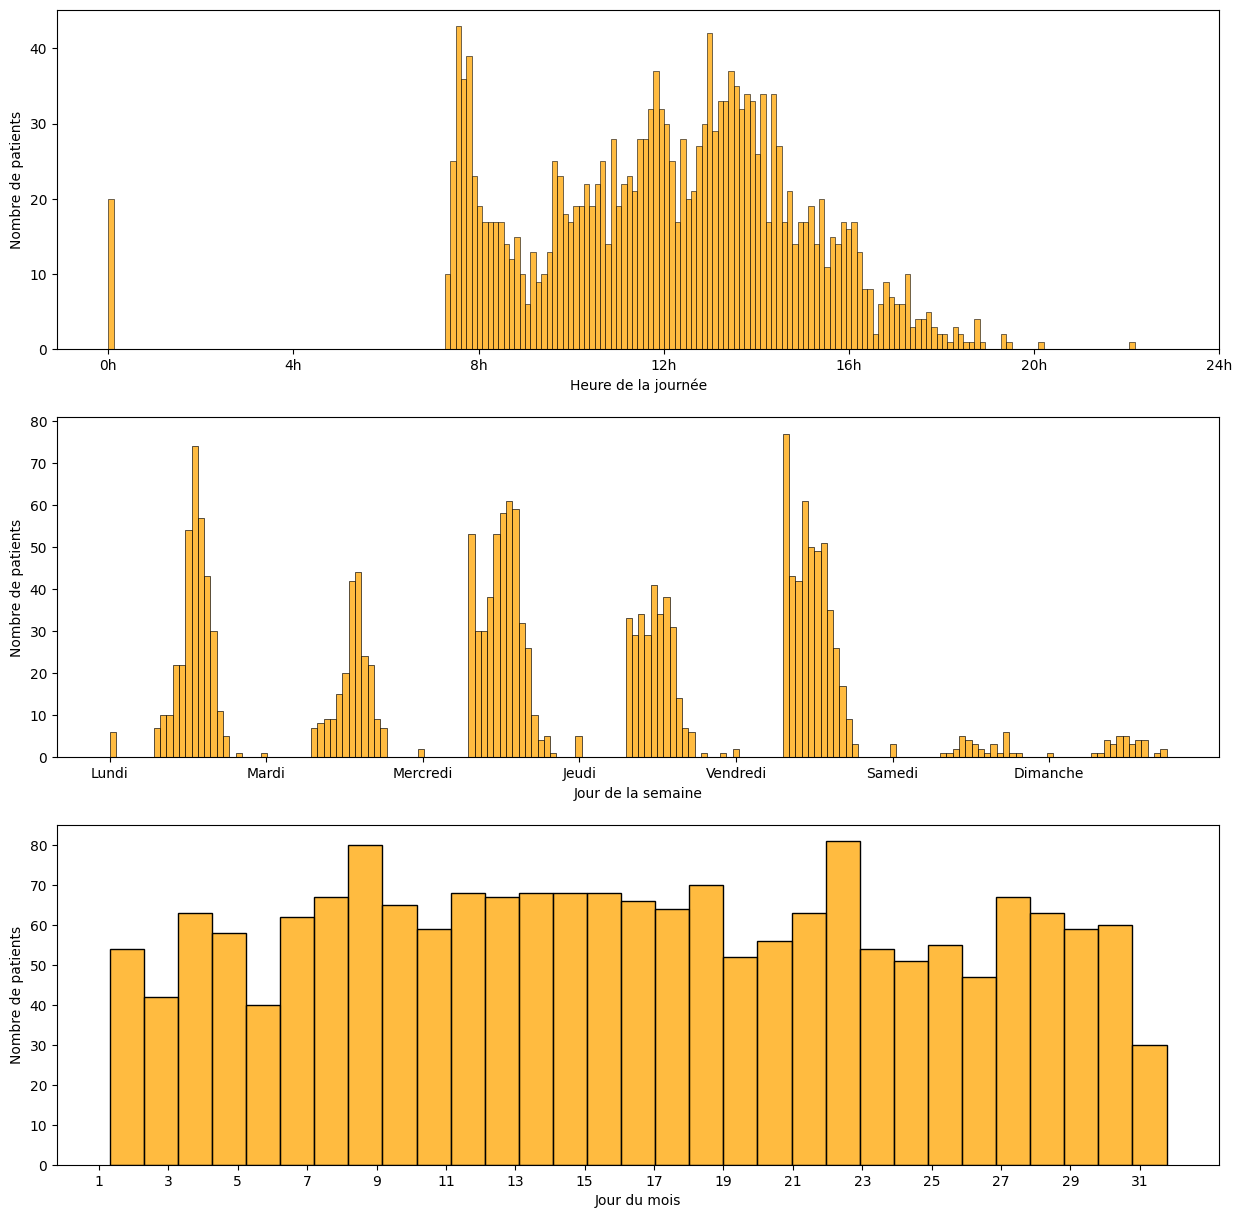

<Figure size 1500x500 with 0 Axes>

In [61]:
time_of_day = timestamp.dt.hour + timestamp.dt.minute / 60
time_of_week = timestamp.dt.day_of_week + time_of_day / 24
day_of_month = timestamp.dt.day + time_of_day / 24
week_of_year = timestamp.dt.dayofyear / 7 + time_of_day / 24


fig, axes = plt.subplots(3, 1, figsize=(15, 15))
plt.figure(figsize=(15, 5))

sns.histplot(data=time_of_day, bins=24*8, label='Heure de la journée', ax=axes[0], color='orange')
axes[0].set_xlabel('Heure de la journée')
axes[0].set_ylabel('Nombre de patients')
axes[0].set_xticks(range(0, 25, 4))
axes[0].set_xticklabels([f'{i}h' for i in range(0, 25, 4)])


sns.histplot(data=time_of_week, bins=7*24, label='Jour de la semaine', ax=axes[1], color='orange')
axes[1].set_xlabel('Jour de la semaine')
axes[1].set_ylabel('Nombre de patients')
axes[1].set_xticks(range(0, 7))
axes[1].set_xticklabels(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])

sns.histplot(data=day_of_month, bins=31, label='Jour du mois', ax=axes[2], color='orange')
axes[2].set_xlabel('Jour du mois')
axes[2].set_ylabel('Nombre de patients')
axes[2].set_xticks(range(1, 32, 2))

[Text(0, 0, 'Lundi'),
 Text(0, 1, 'Mardi'),
 Text(0, 2, 'Mercredi'),
 Text(0, 3, 'Jeudi'),
 Text(0, 4, 'Vendredi'),
 Text(0, 5, 'Samedi'),
 Text(0, 6, 'Dimanche')]

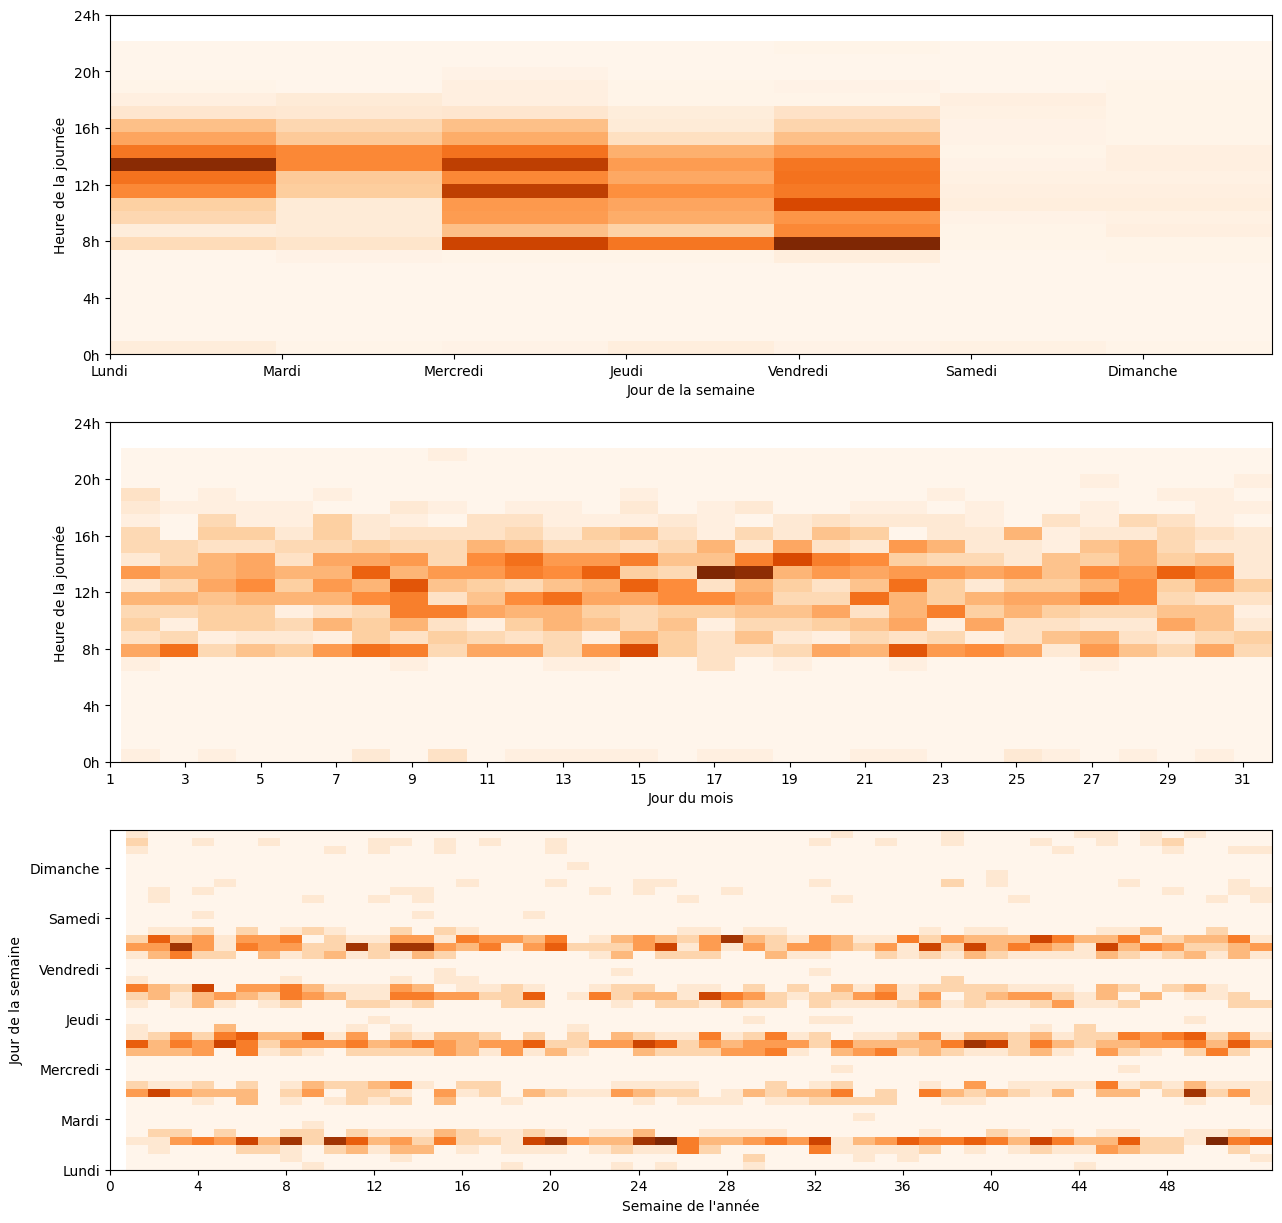

In [81]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

im1 = axes[0].hist2d(time_of_week, time_of_day, bins=(7, 24), cmap='Oranges')
axes[0].set_xlabel('Jour de la semaine')
axes[0].set_ylabel('Heure de la journée')
axes[0].set_xticks(range(0, 7))
axes[0].set_xticklabels(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])
axes[0].set_yticks(range(0, 25, 4))
axes[0].set_yticklabels([f'{i}h' for i in range(0, 25, 4)])

axes[1].hist2d(day_of_month, time_of_day, bins=(30, 24), cmap='Oranges')
axes[1].set_xlabel('Jour du mois')
axes[1].set_ylabel('Heure de la journée')
axes[1].set_xticks(range(1, 32, 2))
axes[1].set_yticks(range(0, 25, 4))
axes[1].set_yticklabels([f'{i}h' for i in range(0, 25, 4)])

axes[2].hist2d(week_of_year, time_of_week, bins=(52, 7*6), cmap='Oranges')
axes[2].set_xlabel('Semaine de l\'année')
axes[2].set_ylabel('Jour de la semaine')
axes[2].set_xticks(range(0, 52, 4))
axes[2].set_xticklabels(range(0, 52, 4))
axes[2].set_yticks(range(0, 7))
axes[2].set_yticklabels(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])


# Prédiction des urgences

Discretisation temporelle des données

In [83]:
timestamp = df['date_entree'] + df['heure_entree_sspi']
urgence = (df['urgence'] == True).astype('int32')

df_urgences = pd.Series(urgence.values, index=timestamp)

df_X = df_urgences.resample(f"{60*24}T", origin='start_day').sum()
df_X = np.array(df_X)

On utilise `Counter` pour vérifier le nombre de valeurs de chaque classe

In [84]:
counts = Counter(df_X)
max_value = next((count for count, rows in counts.items() if rows < 10), 99999)
df_X = df_X.clip(0, max_value - 1)

Counter(df_X)

Counter({0: 642, 1: 342, 2: 255, 3: 143, 4: 71, 5: 34, 6: 21})

On split les données en train et test

On génère les séquences pour l'entrainement du modèle

In [85]:
X_train, X_test = train_test_split(df_X, test_size=0.2, shuffle=False, random_state=69)

def generate_sequences(X, n_steps):
    X = np.array(X)
    X = X.reshape(len(X))
    generator = TimeseriesGenerator(X, X, length=n_steps, batch_size=1)
    return list(generator)

n_steps = 15

# generate sequences for training and testing data
X_train_ts, y_train_ts = zip(*generate_sequences(X_train, n_steps))
X_test_ts, y_test_ts = zip(*generate_sequences(X_test, n_steps))

X_train_ts = np.array(X_train_ts).squeeze()
y_train_ts = np.array(y_train_ts).squeeze()
X_test_ts = np.array(X_test_ts).squeeze()
y_test_ts = np.array(y_test_ts).squeeze()

X_train_ts.shape, y_train_ts.shape, X_test_ts.shape, y_test_ts.shape

((1191, 15), (1191,), (287, 15), (287,))

On utilise OneHotEncoder pour transformer les labels en vecteurs one-hot

In [86]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(df_X.reshape(-1, 1))

y_test_ts_enc = encoder.transform(y_test_ts.reshape(-1, 1)).toarray()
y_train_ts_enc  = encoder.transform(y_train_ts.reshape(-1, 1)).toarray()

num_classes = y_test_ts_enc.shape[1]

On utilise SMOTE pour équilibrer les classes

In [98]:
smt = SMOTE()

X_train_ts_smt, y_train_ts_smt_enc = smt.fit_resample(X_train_ts, y_train_ts_enc)
X_test_ts_smt, y_test_ts_smt_enc = smt.fit_resample(X_test_ts, y_test_ts_enc)

In [99]:
model = Sequential([
#     Conv1D(32, 3, activation='relu', input_shape=(n_steps, 1)),
    Dense(128, activation='relu', input_shape=(n_steps, )),
    Dropout(0.33),
    Dense(64, activation='relu'),
    Dropout(0.33),
    Dense(32, activation='relu'),
    Dropout(0.33),
    Dense(16, activation='relu'),
    Dropout(0.33),
    Dense(num_classes, activation='linear')
])

In [100]:
model.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', 'mse', 'mae']
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 128)               2048      
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dropout_22 (Dropout)        (None, 32)                0         
                                                                 
 dense_28 (Dense)            (None, 16)               

In [101]:
history = model.fit(
    X_train_ts_smt,
    y_train_ts_smt_enc,
    epochs=25,
    validation_data=(X_test_ts_smt, y_test_ts_smt_enc)
)

Epoch 1/25


113/113 [==============================] - 2s 4ms/step - loss: 1.9831 - accuracy: 0.1501 - mse: 0.2757 - mae: 0.3385 - val_loss: 1.9295 - val_accuracy: 0.2039 - val_mse: 0.1322 - val_mae: 0.1806
Epoch 2/25
113/113 [==============================] - 0s 2ms/step - loss: 1.9186 - accuracy: 0.1849 - mse: 0.1826 - mae: 0.2792 - val_loss: 1.8962 - val_accuracy: 0.2377 - val_mse: 0.1397 - val_mae: 0.2128
Epoch 3/25
113/113 [==============================] - 0s 2ms/step - loss: 1.8712 - accuracy: 0.2214 - mse: 0.3026 - mae: 0.3537 - val_loss: 1.8660 - val_accuracy: 0.2039 - val_mse: 0.2497 - val_mae: 0.3194
Epoch 4/25
113/113 [==============================] - 0s 2ms/step - loss: 1.8290 - accuracy: 0.2503 - mse: 0.4939 - mae: 0.4376 - val_loss: 1.8623 - val_accuracy: 0.1896 - val_mse: 0.3257 - val_mae: 0.3762
Epoch 5/25
113/113 [==============================] - 0s 2ms/step - loss: 1.7798 - accuracy: 0.2788 - mse: 0.7336 - mae: 0.5162 - val_loss: 1.8538 - val_accuracy: 0.2169 - val_mse: 0.4607

In [102]:
y_pred_train_enc = model.predict(X_train_ts)
y_pred_test_enc = model.predict(X_test_ts)

eval_train = model.evaluate(X_train_ts, y_train_ts_enc)
eval_test = model.evaluate(X_test_ts, y_test_ts_enc)

print("Training: ", eval_train)
print("Testing:  ", eval_test)

9/9 [==============================] - 0s 1ms/step - loss: 1.7455 - accuracy: 0.3380 - mse: 30.4942 - mae: 3.4298
Training:  [1.2560499906539917, 0.42065492272377014, 33.9398193359375, 3.6576931476593018]
Testing:   [1.7455424070358276, 0.33797910809516907, 30.49423599243164, 3.4297585487365723]


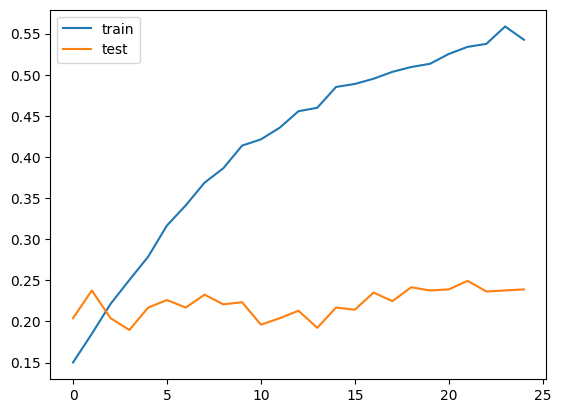

In [103]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

In [104]:
# reverse one hot encoding
y_pred_train = encoder.inverse_transform(y_pred_train_enc)
y_pred_test = encoder.inverse_transform(y_pred_test_enc)

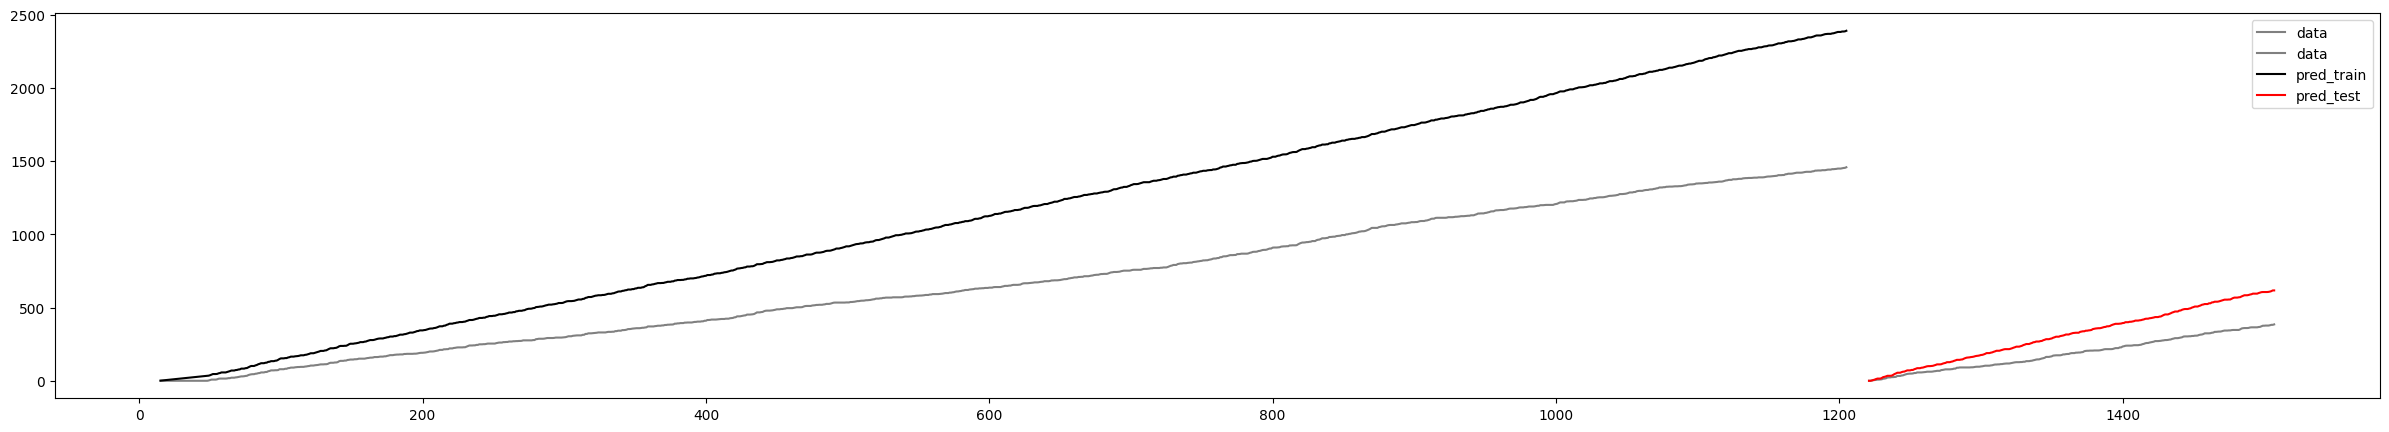

In [107]:
train_range = np.arange(n_steps, len(X_train))
test_range = np.arange(len(X_train) + n_steps, len(X_train) + len(X_test))

plt.figure(figsize=(30, 5))
# plt.plot(range(len(df_X)), df_X, label="data")
plt.plot(train_range, y_train_ts.cumsum(), label='data', c='gray')
plt.plot(test_range, y_test_ts.cumsum(), label='data', c='gray')
plt.plot(train_range, y_pred_train.cumsum(), label="pred_train", c='black')
plt.plot(test_range, y_pred_test.cumsum(), label="pred_test", c='red')
plt.legend()